In [1]:
import sys
sys.path.append("../")

import torch


def _soln2orbit_batch(chi, phi, p, M, e, a):
    """
    Batched version of soln2orbit.
    chi, phi: (B, T)
    p, M, e, a: (B, 4)
    Returns orbit: (B, 2, T)
    """
    r = p * M / (1 + e * torch.cos(chi))
    x = r * torch.cos(phi)
    y = r * torch.sin(phi)
    return torch.stack((x, y), dim=1)


def _orbit2tensor_batch(orbit, component, mass=1.0):
    """
    Batched version of orbit2tensor.
    orbit: (B, 2, T) -> returns (B, T)
    """
    x = orbit[:, 0, :]
    y = orbit[:, 1, :]

    Ixx = x ** 2
    Iyy = y ** 2
    Ixy = x * y
    trace = Ixx + Iyy

    if component == (1, 1):
        tmp = Ixx - (1.0 / 3.0) * trace
    elif component == (2, 2):
        tmp = Iyy - (1.0 / 3.0) * trace
    else:
        tmp = Ixy

    return mass * tmp


def _d_dt_batch(v, dt):
    """
    Batched numerical derivative along last dim using second-order one-sided stencils.
    v: (B, T) -> returns (B, T)
    """
    a = (-1.5 * v[:, 0] + 2 * v[:, 1] - 0.5 * v[:, 2])
    b = (v[:, 2:] - v[:, :-2]) / 2
    c = (1.5 * v[:, -1] - 2 * v[:, -2] + 0.5 * v[:, -3])
    return torch.cat((a[:, None], b, c[:, None]), dim=1) / dt


def d2_dt2(v, dt):
    """
    Numerical second derivative using second-order one-sided difference stencils at the endpoints.
    """
    if isinstance(dt, torch.Tensor):
        dt = dt.item()
    dv_dt = torch.gradient(v, spacing=(dt,), dim=-1)[0]
    return torch.gradient(dv_dt, spacing=(dt,), dim=-1)[0]

def _smooth_1d_batch(v, window=5):
    """
    v: (B, T)
    """
    if window <= 1:
        return v
    pad = window // 2
    kernel = torch.ones(window, device=v.device, dtype=v.dtype) / window
    v_pad = torch.nn.functional.pad(v[:, None, :], (pad, pad), mode="replicate")
    return torch.nn.functional.conv1d(v_pad, kernel[None, None, :]).squeeze(1)


def _h_22_quadrupole_components_batch(dt, orbit, component, mass=1.0, smooth_window=21):
    """
    orbit: (B, 2, T)
    """
    mtensor = _orbit2tensor_batch(orbit, component, mass)
    if smooth_window and smooth_window > 1:
        mtensor = _smooth_1d_batch(mtensor, window=smooth_window)
    mtensor_ddot = d2_dt2(mtensor, dt)
    return 2 * mtensor_ddot


def _h_22_quadrupole_batch(dt, orbit, mass=1.0, smooth_window=21):
    h11 = _h_22_quadrupole_components_batch(dt, orbit, (1, 1), mass, smooth_window=smooth_window)
    h22 = _h_22_quadrupole_components_batch(dt, orbit, (2, 2), mass, smooth_window=smooth_window)
    h12 = _h_22_quadrupole_components_batch(dt, orbit, (1, 2), mass, smooth_window=smooth_window)
    return h11, h12, h22


def _h_22_strain_one_body_batch(dt, orbit, smooth_window=21):
    h11, h12, h22 = _h_22_quadrupole_batch(dt, orbit, smooth_window=smooth_window)
    h_plus = h11 - h22
    h_cross = 2.0 * h12
    scaling_const = torch.sqrt(torch.tensor(torch.pi / 5, device=orbit.device, dtype=orbit.dtype))
    return scaling_const * h_plus, -scaling_const * h_cross


def _h_22_quadrupole_two_body_batch(dt, orbit1, mass1, orbit2, mass2):
    h11_1, h12_1, h22_1 = _h_22_quadrupole_batch(dt, orbit1, mass1)
    h11_2, h12_2, h22_2 = _h_22_quadrupole_batch(dt, orbit2, mass2)
    h11 = h11_1 + h11_2
    h12 = h12_1 + h12_2
    h22 = h22_1 + h22_2
    return h11, h12, h22


def _h_22_strain_two_body_batch(dt, orbit1, mass1, orbit2, mass2):
    h11, h12, h22 = _h_22_quadrupole_two_body_batch(dt, orbit1, mass1, orbit2, mass2)
    h_plus = h11 - h22
    h_cross = 2.0 * h12
    scaling_const = torch.sqrt(torch.tensor(torch.pi / 5, device=orbit1.device, dtype=orbit1.dtype))
    return scaling_const * h_plus, -scaling_const * h_cross


def compute_waveform(
    u,
    system_params,
    smooth_window: int = 21,
):
    """
    Batched waveform computation.

    Inputs:
    - u: Tensor (B, 2, T)
    - model_params: [p, M, e, a] (B, 4)
    Returns:
    - waveform: (h_plus, h_cross) each (B, 2, T)
    """
    chi = u[:, 0, :]
    phi = u[:, 1, :]

    p = system_params['p']
    M = system_params['M']
    e = system_params['e']
    a = system_params['a']
    dt = system_params['dt_data'][0]

    orbit = _soln2orbit_batch(chi, phi, p, M, e, a)

    # if mass_ratio > 0:
    #     mass1 = M * mass_ratio / (1.0 + mass_ratio)
    #     mass2 = M / (1.0 + mass_ratio)
    #     orbit1, orbit2 = one2two(orbit, mass1, mass2)
    #     waveform = _h_22_strain_two_body_batch(dt, orbit1, mass1, orbit2, mass2)
    # else:
    waveform, _ = _h_22_strain_one_body_batch(dt, orbit, smooth_window=smooth_window)

    return waveform


# Note: file reading functions would typically use python file I/O and 
# convert data to torch tensors after reading.

def file2waveform(tsteps, filename="waveform.txt"):
    """
    Reads waveform data file and interpolates to tsteps.
    """
    data = torch.tensor(torch.loadtxt(filename))  # Replace with appropriate PyTorch file reading if needed
    tdata = data[:, 0]
    wdata = data[:, 1]

    waveform = interpolate_time_series(tsteps, tdata, wdata)
    return waveform


def file2trajectory(tsteps, filename="trajectoryA.txt"):
    """
    Reads trajectory data file and interpolates to tsteps.
    """
    data = torch.tensor(torch.loadtxt(filename))  # Replace with appropriate PyTorch file reading if needed
    tdata = data[:, 0]
    xdata = data[:, 1]
    ydata = data[:, 2]

    x = interpolate_time_series(tsteps, tdata, xdata)
    y = interpolate_time_series(tsteps, tdata, ydata)

    return x, y


def interpolate_time_series(tsteps, tdata, fdata):
    """
    Interpolate time series to adapt the waveform length.

    Assumes tsteps, tdata, fdata are 1D torch tensors.
    """
    assert tdata.numel() == fdata.numel(), "lengths of tdata and fdata must match"

    interp_fdata = torch.zeros(len(tsteps), device=tdata.device)

    for j, tj in enumerate(tsteps):
        # Find interval in tdata that contains tj
        for i in range(len(tdata) - 1):
            if tdata[i] <= tj < tdata[i + 1]:
                weight = (tj - tdata[i]) / (tdata[i + 1] - tdata[i])
                interp_fdata[j] = (1 - weight) * fdata[i] + weight * fdata[i + 1]
                break
    return interp_fdata

In [2]:
import math


def generate_mesh(tspan, dt, factor=1):
    t_start, t_end = tspan
    t_end *= factor
    datasize = math.ceil((t_end - t_start) / dt)
    tsteps = torch.linspace(t_start, t_end, datasize * factor, dtype=torch.float64)
    return {"tsteps": tsteps, "dt_data": torch.tensor([dt])}


import torch

class RelativisticOrbitModelSchwarzschildODE(torch.nn.Module):
    def __init__(self, p, M, e):
        super().__init__()
        self.p = p
        self.M = M
        self.e = e

    def forward(self, t, u):
        chi, phi = torch.unbind(u, dim=1)
        p = self.p
        M = self.M
        e = self.e

        numer = (p - 2 - 2 * e * torch.cos(chi)) * (1 + e * torch.cos(chi))**2
        denom = torch.sqrt((p - 2)**2 - 4 * e**2)

        phi_dot = numer / (M * p**1.5 * denom)
        chi_dot = numer * torch.sqrt(p - 6 - 2 * e * torch.cos(chi)) / (M * p**2 * denom)
        return torch.cat([chi_dot, phi_dot], dim=1)


def solve_ode_rk4(ode_problem, system_params):
    """
    Computes true solution of a Kerr system using an explicit RK4 integrator.
    This keeps the solution fully differentiable with torch autograd.
    """

    u = system_params['u0']
    us = [u]
    tsteps = system_params['tsteps'][0, :]

    for i in range(1, tsteps.numel()):
        t_prev = tsteps[i - 1]
        dt_i = tsteps[i] - t_prev

        k1 = ode_problem(t_prev, u)
        k2 = ode_problem(t_prev + 0.5 * dt_i, u + 0.5 * dt_i * k1)
        k3 = ode_problem(t_prev + 0.5 * dt_i, u + 0.5 * dt_i * k2)
        k4 = ode_problem(t_prev + dt_i, u + dt_i * k3)

        u = u + (dt_i / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

        us.append(u)

    u = torch.stack(us, dim=-1)
    return u


def solve_ode_rk2(ode_problem, system_params):
    """
    Midpoint (RK2) integrator.
    Fully differentiable with torch autograd.
    """
    u = system_params['u0']
    us = [u]
    tsteps = system_params['tsteps'][0, :]

    for i in range(1, tsteps.numel()):
        t_prev = tsteps[i - 1]
        dt_i = tsteps[i] - t_prev

        k1 = ode_problem(t_prev, u)
        u_mid = u + 0.5 * dt_i * k1
        k2 = ode_problem(t_prev + 0.5 * dt_i, u_mid)

        u = u + dt_i * k2
        us.append(u)

    return torch.stack(us, dim=-1)


def trim_item(item, trim_window=50):
    """
    Trim the first and last elements n from the waveform, the solution and tsteps
    """
    item['solution'] = item['solution'][:, trim_window:-trim_window]
    item['waveform'] = item['waveform'][:, trim_window:-trim_window]
    item['tsteps'] = item['tsteps'][:, trim_window:-trim_window]
    return item


from torch.utils.data import Dataset


class OrbitDataset(Dataset):

    def __init__(self, chi0: float, phi0: float, p_space: list, M: float, e: float, a: float, train_mesh):
        self.data_list = []
        self._generate_data(chi0, phi0, p_space, M, e, a, train_mesh)


    def _generate_data(self, chi0, phi0, p_space, M, e, a, train_mesh):

        for p in p_space:

            system_params = {
                # mesh
                "tsteps": train_mesh["tsteps"].unsqueeze(0),
                "dt_data": train_mesh["dt_data"].unsqueeze(0),
                # system
                "u0": torch.tensor([chi0, phi0], dtype=torch.float64).unsqueeze(0),
                "p": torch.tensor([p], dtype=torch.float64).unsqueeze(0),
                "M": torch.tensor([M], dtype=torch.float64).unsqueeze(0),
                "e": torch.tensor([e], dtype=torch.float64).unsqueeze(0),
                "a": torch.tensor([a], dtype=torch.float64).unsqueeze(0)
            }
            ode_problem = RelativisticOrbitModelSchwarzschildODE(
                p=system_params['p'],
                M=system_params['M'],
                e=system_params['e'],
            )
            system_solution = solve_ode_rk2(
                ode_problem=ode_problem,
                system_params=system_params
            )
            system_waveform = compute_waveform(u=system_solution, system_params=system_params)

            item = system_params | {'solution': system_solution, 'waveform': system_waveform}

            item = trim_item(item)

            item = {k: v.squeeze(0) for k, v in item.items()}  # remove batch dim for storage
            self.data_list.append(item)
            
            print(f"Generated training data for system: p: {system_params['p']}")

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        return item


dataset size: 1500
Generated training data for system: p: tensor([[100.]], dtype=torch.float64)
Generated training data for system: p: tensor([[30.]], dtype=torch.float64)


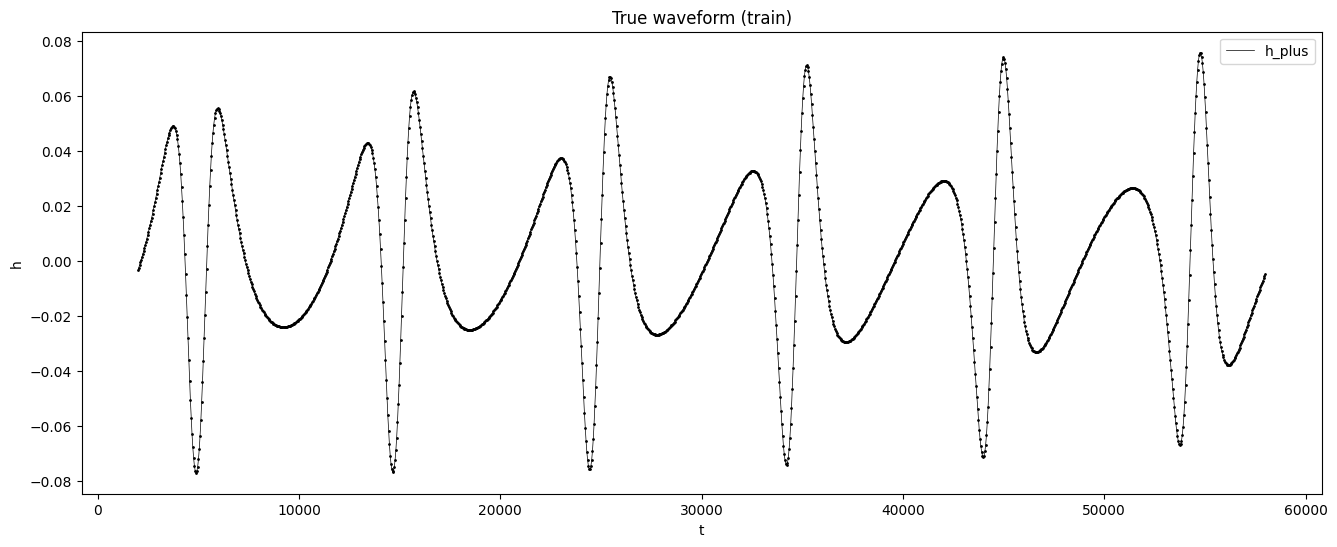

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set seeds for reproducibility
seed = 1234
torch.manual_seed(seed)

# Dataset
chi0 = math.pi
phi0 = 0.0
M = 1.0
e = 0.5
a = 0.0

dt = 40
tspan = torch.tensor([0, 60000])
print(f"dataset size: {int(tspan[1] / dt)}")
train_mesh = generate_mesh(tspan, dt, factor=1)


train_dataset = OrbitDataset(
    phi0=phi0,
    chi0=chi0,
    p_space=[100],#[20, 40, 50, 60],
    M=M,
    e=e,
    a=a,
    train_mesh=train_mesh
)

val_dataset = OrbitDataset(
    phi0=phi0,
    chi0=chi0,
    p_space=[30],
    M=M,
    e=e,
    a=a,
    train_mesh=train_mesh
)

import matplotlib.pyplot as plt

def plot_waveform(waveform_info, ax=None, label="h_plus", title=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(16,6))
    t = waveform_info["tsteps"].detach().cpu().numpy()
    h = waveform_info["waveform"].detach().cpu().numpy()
    ax.plot(t, h, '.', markersize=2, color='k')
    ax.plot(t, h, '-', label=label, linewidth=0.5, color='k')
    ax.set_xlabel("t")
    ax.set_ylabel("h")
    if title:
        ax.set_title(title)
    ax.legend()
    return ax

plot_waveform(train_dataset[0], title="True waveform (train)")
plt.show();

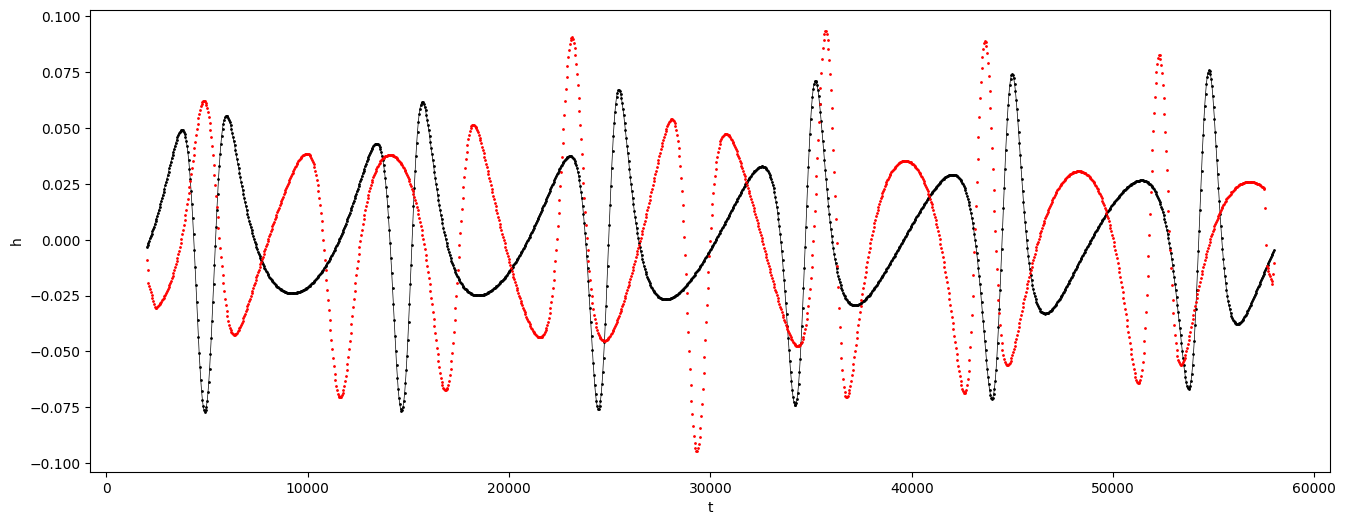

In [4]:
import torch.nn as nn 


class NNOrbitModel_Newton_EMR(nn.Module):
    
    def __init__(self, p, M , e, network):
        super().__init__()
        self.p = p
        self.M = M
        self.e = e
        self.network = network

    def forward(self, t, u):
        
        χ, ϕ = torch.unbind(u, dim=1)
        χ = χ.unsqueeze(1)  # (B, 1)
        ϕ = ϕ.unsqueeze(1)  # (B, 1

        # Output should be a (B,2) - element tensor (e.g., [Δχ̇, Δϕ̇])
        out = 1 + self.network(u)

        numer = (1 + self.e * torch.cos(χ)) ** 2
        denom = self.M * (self.p ** 1.5)
        χ_dot = (numer / denom) * out[:, 0].unsqueeze(1)
        ϕ_dot = (numer / denom) * out[:, 1].unsqueeze(1)
        
        return torch.cat([χ_dot, ϕ_dot], dim=1)


class NNOrbitModel_Schwarzcshild_EMR(nn.Module):
    
    def __init__(self, p, M , e, network):
        super().__init__()
        self.p = p
        self.M = M
        self.e = e
        self.network = network

    def update_params(self, p=None, M=None, e=None):
        if p is not None: 
            self.p = p 
        if M is not None: 
            self.M = M 
        if e is not None: 
            self.e = e

    def forward(self, t, u):
        
        χ, ϕ = torch.unbind(u, dim=1)
        χ = χ.unsqueeze(1)  # (B, 1)
        ϕ = ϕ.unsqueeze(1)  # (B, 1

        # Output should be a (B,2) - element tensor (e.g., [Δχ̇, Δϕ̇])
        out = 1 + self.network(u)

        numer = (self.p-2-2*self.e*torch.cos(χ)) * (1+self.e*torch.cos(χ))**2
        denom = torch.sqrt( (self.p-2)**2-4*self.e**2 )

        χ_dot = (numer / (self.M*(self.p**(3/2))*denom)) * out[:, 0].unsqueeze(1)
        ϕ_dot = (numer * torch.sqrt( self.p-6-2*self.e*torch.cos(χ) )/( self.M*(self.p**2)*denom )) * out[:, 1].unsqueeze(1)
        
        return torch.cat([χ_dot, ϕ_dot], dim=1)


import torch.nn as nn


# Helper function: to create a lambda layer
class LambdaLayer(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)


class Cosine(nn.Module):
    def forward(self, x):
        return torch.cos(x)


class BasicNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            LambdaLayer(lambda x: torch.stack([torch.cos(x[:,0]), x[:,0]], dim=1)),
            nn.Linear(2, 64),
            Cosine(),
            # nn.Linear(64, 64),
            # Cosine(),
            nn.Linear(64, 2)
        )
        for l in self.model:
            if hasattr(l, 'weight'):
                torch.nn.init.uniform_(l.weight, -0.1,0.1)
        #         # torch.nn.init.zeros_(l.weight)

    def forward(self, x):
        return self.model(x)


model = BasicNN()
model.to(device).double()


batch = train_dataset[0]
batch = {k: v.unsqueeze(0).to(device) for k, v in batch.items()} # add batch dim and move to device


# frame the ODE problem for the current batch
ode_problem = NNOrbitModel_Schwarzcshild_EMR(
    p=batch['p'],
    M=batch['M'],
    e=batch['e'],
    network=model
)

# Predict orbit (chi, phi) for each t
system_solution = solve_ode_rk2(
    ode_problem=ode_problem,
    system_params=batch
)

# compute true waveform for the current batch
pred_waveform = compute_waveform(u=system_solution, system_params=batch)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,6))
t = batch["tsteps"][0].detach().cpu().numpy()
h = batch["waveform"][0].detach().cpu().numpy()
h_pred = pred_waveform[0].detach().cpu().numpy()
ax.plot(t, h, '.', markersize=2, color='k')
ax.plot(t, h, '-', label="True Waveform", linewidth=0.5, color='k')
ax.plot(t, h_pred, '.', markersize=2, color='r', label="Predicted Waveform")
ax.set_xlabel("t")
ax.set_ylabel("h")
plt.show();

Adam to slow...? -> Try LBFGS? uses curvatures

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import tqdm.notebook as tdqm


seed = 1234
torch.manual_seed(seed)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 20
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, history_size=60, line_search_fn="strong_wolfe")

num_iterations = num_epochs * len(train_loader)
progress_bar = tdqm.tqdm(total=num_iterations, desc="Training")

iterations = 0

train_loss = []

model.train()

for batch in train_loader:
    break
ode_problem = NNOrbitModel_Schwarzcshild_EMR(
    p=batch['p'],
    M=batch['M'],
    e=batch['e'],
    network=model
)

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch in train_loader:

        batch = {k: v.to(device) for k, v in batch.items()}  # move to device

        def closure():
            
            # zero gradients
            optimizer.zero_grad()

            # frame the ODE problem for the current batch
            ode_problem.update_params(p=batch['p'], M=batch['M'], e=batch['e'])
            
            # Predict orbit (chi, phi) for each t
            system_solution = solve_ode_rk2(
                ode_problem=ode_problem,
                system_params=batch
            )
            # compute true waveform for the current batch
            pred_waveform = compute_waveform(u=system_solution, system_params=batch)

            # compute loss
            y_true = batch["waveform"].to(device)  # shape [B, T]
            loss = F.l1_loss(pred_waveform, y_true)

            # accumulate gradients and update parameters
            loss.backward()
            return loss
        
        loss = optimizer.step(closure=closure)

        train_loss.append(loss.item() / batch_size)

        epoch_loss += loss.item()
        progress_bar.update(1)
        iterations += 1
        
        # if (iterations) % 10 == 0:
        print(f"Iteration {iterations}: loss={loss.item():.6f}")

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 1: loss=0.043262


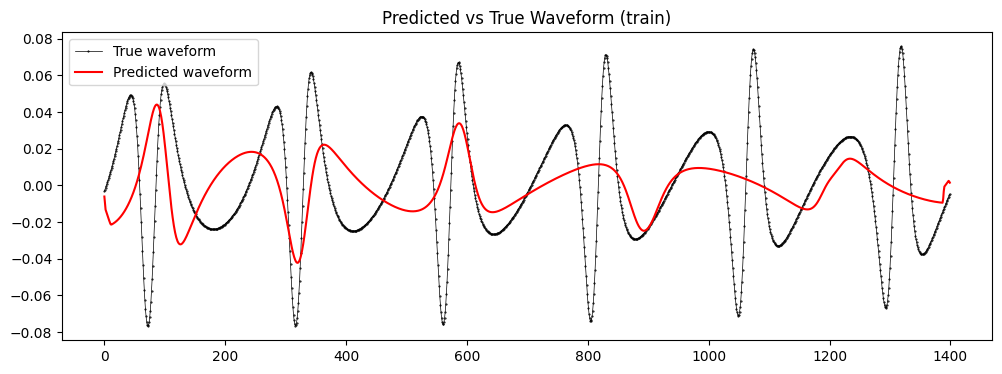

In [ ]:
# frame the ODE problem for the current batch
ode_problem = NNOrbitModel_Schwarzcshild_EMR(
    p=batch['p'],
    M=batch['M'],
    e=batch['e'],
    network=model
)
# Predict orbit (chi, phi) for each t
system_solution = solve_ode_rk4(
    ode_problem=ode_problem,
    system_params=batch
)
# compute true waveform for the current batch
pred_waveform = compute_waveform(u=system_solution, system_params=batch)

plt.figure(figsize=(12,4))
plt.title("Predicted vs True Waveform (train)")
plt.plot(batch['waveform'][0].detach().cpu().numpy(), '.-', markersize=1, linewidth=0.5, label="True waveform", color='k');
plt.plot(pred_waveform[0].detach().cpu().numpy(), label="Predicted waveform", color='r');
plt.legend()